<a target="_blank" href="https://colab.research.google.com/github/trainocate-japan/Machine-Learning-and-Deep-Learning-Hands-on/blob/main/answer/5_勾配ブースティング木/5-1_LightGBMによる戸建ての価格予測.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 5-1_LightGBMによる戸建ての価格予測

このノートブックでは、勾配ブースティング木の中でも特に速度精度が高く注目されているLightGBMを使用して予測モデルを作成します。<br>
LightGBMはMicrosoftが開発する機械学習アルゴリズムで、構造化データに対して高い精度が出やすく、データ分析コンペでもLightGBMを利用した入賞者が多く出ています。

予測を行うテーマは決定木・ランダムフォレストと同じ戸建て物件の価格を予測することです。

LightGBMも回帰にも分類にも用いることができ、用途に応じて以下の二つのモデルを使い分けます。
- 回帰：lightgbm.LGBMRegressor
- 分類：lightgbm.LGBMClassifier

[LightGBMのAPIドキュメント](https://lightgbm.readthedocs.io/en/latest/Python-API.html)

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# LightGBMモデルをインポート
from lightgbm import LGBMRegressor

In [3]:
# matplotlibで日本語表示するための設定
!pip install japanize_matplotlib | tail -n 1
import japanize_matplotlib

そのほかGoogle Colaboratory上での出力のデフォルト設定をしておくと、結果を確認しやすくなるので、ここで設定しておきます。

In [4]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 3
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=3)

## データの準備
mlho/data/totsuka_kodate.csvファイルを読み込みます

In [5]:
# データの読み込み。mlho/data/totsuka_kodate.csv
totsuka_kodate = pd.read_csv("/content/drive/MyDrive/mlho/data/totsuka_kodate.csv")
# 説明変数と目的変数の切り分け
x = pd.get_dummies( totsuka_kodate[['築年数','最寄駅距離（分）','延床面積（㎡）','面積（㎡）','前面道路幅員（ｍ）','地区名', '前面道路種類', '土地の形状']])
y = totsuka_kodate['取引価格']
# 訓練データと検証データに分割(70%を訓練用に使用)
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=8)

## モデルの定義

In [6]:
model = LGBMRegressor(random_state=0)

## モデルの学習

In [7]:
model.fit(train_x,train_y)

LGBMRegressor(random_state=0)

## 評価

In [8]:
# 訓練データで精度を確認してみる
model.score(train_x, train_y)

0.815

In [9]:
# 検証データで精度を確認してみる
model.score(val_x, val_y)

0.687

LightGBMもデフォルトのハイパーパラメータで高い精度が出ています。パラメータチューニングを行うことで、さらに良い精度が得られる可能性があります。

## LightGBMのパラメータチューニング

LightGBMのハイパーパラメータを調整します。

LightGBMのハイパーパラメータのうち特に重要なハイパーパラメータは以下です。

- **learning_rate:**学習率。次の決定木を作成し予測値をアップデートする際にこの値を乗算することによって影響を小さくする調整を入れる。
- **n_estimators:**決定木の数
- **max_depth:**個々の決定木の最大深さ
- **num_leaves：**1本の木の葉の最大数
- **colsample_bytree:**決定木ごとに列をサンプリングする割合
- **subsample:**決定木ごとに学習データの行をサンプリングする割合

[LightGBMのAPIドキュメント](https://lightgbm.readthedocs.io/en/latest/Python-API.html)


In [10]:
# LightGBMで学習を実行
model = LGBMRegressor(learning_rate = 0.1, n_estimators=70, num_leaves=4, random_state=0)
model.fit(train_x,train_y)

LGBMRegressor(n_estimators=70, num_leaves=4, random_state=0)

In [11]:
# 訓練データで精度を確認してみる
model.score(train_x, train_y)

0.748

In [12]:
# 検証データで精度を確認してみる
model.score(val_x, val_y)

0.733

**※ 調整例**

`model = LGBMRegressor(learning_rate = 0.1, n_estimators=70, num_leaves=4, random_state=0)`

73%程の精度が出ます。

## 交差検証とグリッドサーチ
パラメータチューニングについて、今回はここに交差検証、グリッドサーチという新たな方法を取り入れます。

In [13]:
# 交差検証とグリッドサーチ用のライブラリをインポート
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [14]:
# 探索したいパラメーターをディクショナリで設定する
param_grid = {"learning_rate":[0.1],
              "num_leaves": [3, 4, 5],
              "colsample_bytree": [0.6, 0.8, 1],
              "subsample": [0.6, 0.8, 1],
              "n_estimators":[50, 70 ,100]
             } 
# パラメータチューニングをグリッドサーチ
gscv = GridSearchCV(estimator = LGBMRegressor(random_state = 0), # パラメータ探索するモデル
                           param_grid = param_grid, # 探索するパラメータのリスト
                           cv = 4, # 交差検証のデータの分割数
                           verbose=2) # ログをどれだけ出力するか。進み具合のわかる2がおすすめ

gscv.fit(x, y) # 分割前の全データを使用

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, n_estimators=50, num_leaves=3, subsample=0.8; total time=   0.0s
[CV] END colsample

GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=0),
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'learning_rate': [0.1], 'n_estimators': [50, 70, 100],
                         'num_leaves': [3, 4, 5], 'subsample': [0.6, 0.8, 1]},
             verbose=2)

In [15]:
# スコアの一覧を取得
gs_result = pd.DataFrame.from_dict(gscv.cv_results_)
gs_result.sort_values('rank_test_score')[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_n_estimators,param_num_leaves,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,0.01058,0.00045,0.00296,0.00010,0.60000,0.10000,70,4,1,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",0.03624,0.62457,0.64406,0.50279,0.45192,0.24602,1
12,0.01260,0.00366,0.00298,0.00010,0.60000,0.10000,70,4,0.60000,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",0.03624,0.62457,0.64406,0.50279,0.45192,0.24602,1
13,0.01348,0.00321,0.00434,0.00230,0.60000,0.10000,70,4,0.80000,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",0.03624,0.62457,0.64406,0.50279,0.45192,0.24602,1


In [16]:
# 最高性能のモデルを取得
best = gscv.best_estimator_
best

LGBMRegressor(colsample_bytree=0.6, n_estimators=70, num_leaves=4,
              random_state=0, subsample=0.6)

In [17]:
# 参考に全データを用いて精度を確認してみる
best.score(x, y)

0.754

チューニングの仕方にもよりますが、パラメータ調整をする前とあまり変わらない精度になったかもしれません。これは、見た目どおりあまり精度が向上していない可能性もありますが、交差検証で精度を確認しているため、これまで計算していた精度よりも信頼性の高い精度だと考えることができます。

## 特徴量（説明変数）の重要度を確認する
LightGBMでも木の作成に使われた特徴量（説明変数）のうち重要なものが何であったかを定量的に出力することもできます。<br>
決定木の場合と比べると、それぞれの木が別の特徴量を使用して予測を行うため、より多くの情報から重要度を考えることができます。

In [18]:
# 特徴量重要度
importances= best.feature_importances_
df_importances =pd.DataFrame(data=importances, index=train_x.columns)
df_importances.sort_values(0, ascending=False)

,0
最寄駅距離（分）,46
築年数,36
面積（㎡）,31
延床面積（㎡）,26
前面道路幅員（ｍ）,21
地区名_戸塚町,10
土地の形状_袋地等,9
地区名_上矢部町,6
土地の形状_不整形,6
土地の形状_ほぼ長方形,5


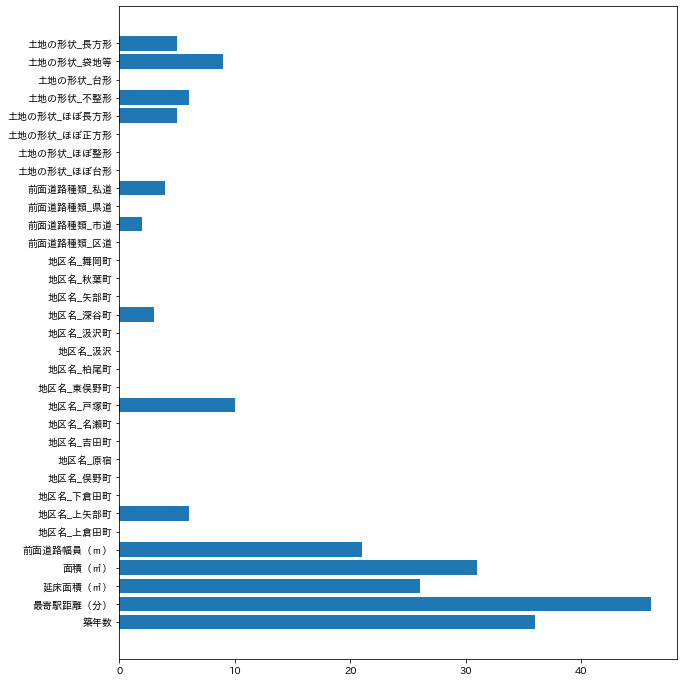

In [19]:
# （参考）matplotlibで画像サイズの調整（横幅、縦幅）
plt.figure(figsize=(10,12))
n_features = train_x.shape[1] # 特徴量の数
plt.barh(range(n_features), best.feature_importances_, align='center')
plt.yticks(np.arange(n_features), train_x.columns)
plt.plot;